### Introduction

This notebook helps to have a first look at the saved output, reading into hdf files. 

It works after having installed the repo 'legend-data-monitor'. In particular, after the cloning, enter into the folder and install the package by typing

```console
foo@bar:~$ pip install .
```

# Select run to inspect

In [1]:
# ------------------------------------------------------------------------------------------ which data do you want to read? CHANGE ME!
run = "r000"  # r000, r001, ...
subsystem = "geds"  # KEEP 'geds' for the moment
folder = "prod-ref-v2"  # you can change me
period = "p06"
version = ""  # leave an empty string if you're looking at p03 data

if version == "":
    data_file = f"/data1/users/calgaro/{folder}/generated/plt/phy/{period}/{run}/l200-{period}-{run}-phy-{subsystem}.hdf"
else:
    data_file = f"/data1/users/calgaro/{folder}/{version}/generated/plt/phy/{period}/{run}/l200-{period}-{run}-phy-{subsystem}.hdf"

# Select event type, parameter and original or PULS01ANA-rescaled values

In [2]:
# ------------------------------------------------------------------------------------------ ...from here, you don't need to change anything in the code
import sys
import h5py
import shelve
import matplotlib
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from legend_data_monitor import plot_styles, plotting, utils
import legend_data_monitor as ldm

%matplotlib widget

# ------------------------------------------------------------------------------------------ building channel map
dataset = {
    "experiment": "L200",
    "period": period,
    "type": "phy",
    "version": version,
    "path": "/data2/public/prodenv/prod-blind/tmp/auto",
    "runs": int(run[1:]),
}

geds = ldm.Subsystem("geds", dataset=dataset)
channel_map = geds.channel_map

# remove probl dets
to_be_excluded = [
    "V01406A",
    "V01415A",
    "V01387A",
    "P00665C",
    "P00748B",
    "P00748A",
    "B00089D",
]
for det in to_be_excluded:
    channel_map = channel_map[channel_map.name != det]
# remove OFF dets
channel_map = channel_map[channel_map.status == "on"]


# ------------------------------------------------------------------------------------------ load data
# Load the hdf file
hdf_file = h5py.File(data_file, "r")
keys = list(hdf_file.keys())
hdf_file.close()

# available flags - get the list of available event types
event_types = list(set([key.split("_")[0] for key in keys]))

# Create a dropdown widget for the event type
evt_type_widget = widgets.Dropdown(options=event_types, description="Event Type:")


# ------------------------------------------------------------------------------------------ parameter
# Define a function to update the parameter dropdown based on the selected event type
def update_params(*args):
    selected_evt_type = evt_type_widget.value
    params = list(
        set(
            [
                key.split("_")[1]
                for key in keys
                if key.split("_")[0] == selected_evt_type
            ]
        )
    )
    param_widget.options = params


# Call the update_params function when the event type is changed
evt_type_widget.observe(update_params, "value")

# Create a dropdown widget for the parameter
param_widget = widgets.Dropdown(description="Parameter:")

# ------------------------------------------------------------------------------------------ data format
data_format = ["absolute values", "% values"]

# Create a dropdown widget
data_format_widget = widgets.Dropdown(options=data_format, description="data format:")

# ------------------------------------------------------------------------------------------ plot structure
plot_structures = ["per string", "per channel"]

# Create a dropdown widget
plot_structures_widget = widgets.Dropdown(
    options=plot_structures, description="Plot structure:"
)

# ------------------------------------------------------------------------------------------ plot style
plot_styles = ["vs time", "histogram"]

# Create a dropdown widget
plot_styles_widget = widgets.Dropdown(options=plot_styles, description="Plot style:")

# ------------------------------------------------------------------------------------------ resampling
resampled = ["no", "only", "also"]

# Create a dropdown widget
resampled_widget = widgets.Dropdown(options=resampled, description="Resampled:")


# ------------------------------------------------------------------------------------------ get one or all strings
strings = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, "all"]

# Create a dropdown widget
strings_widget = widgets.Dropdown(options=strings, description="String:")

# ------------------------------------------------------------------------------------------ display widgets
display(evt_type_widget)
display(param_widget)

# ------------------------------------------------------------------------------------------ get params (based on event type)
evt_type = evt_type_widget.value
params = list(set([key.split("_")[1] for key in keys if key.split("_")[0] == evt_type]))
param_widget.options = params


aux_widget = widgets.Dropdown(description="Options:")
print(
    "Pick the way you want to include PULS01ANA info\n(this is not available for EventRate, CuspEmaxCtcCal \nand AoECustom; in this case, select None):"
)
display(aux_widget)

aux_info = ["pulser01anaRatio", "pulser01anaDiff", "None"]
aux_dict = {
    "pulser01anaRatio": f"Ratio: {subsystem} / PULS01ANA",
    "pulser01anaDiff": f"Difference: {subsystem} - PULS01ANA",
    "None": f"None (ie just plain {subsystem} data)",
}
aux_info = [aux_dict[info] for info in aux_info]
aux_widget.options = aux_info

print("\033[91mIf you change me, then RUN AGAIN the next cell!!!\033[0m")

2023-06-27 10:18:19,799:  ---------------------------------------------
2023-06-27 10:18:19,800:  --- S E T T I N G  UP : geds
2023-06-27 10:18:19,801:  ---------------------------------------------
2023-06-27 10:18:19,827:  ... getting channel map
2023-06-27 10:18:20,742:  ... getting channel status


Dropdown(description='Event Type:', options=('IsPulser', 'IsBsln'), value='IsPulser')

Dropdown(description='Parameter:', options=(), value=None)

Pick the way you want to include PULS01ANA info
(this is not available for EventRate, CuspEmaxCtcCal 
and AoECustom; in this case, select None):


Dropdown(description='Options:', options=(), value=None)

If you change me, then RUN AGAIN the next cell!!!


In [4]:
def to_None(string):
    return None if string == "None" else string


# ------------------------------------------------------------------------------------------ get dataframe
def display_param_value(*args):
    selected_evt_type = evt_type_widget.value
    selected_param = param_widget.value
    selected_aux_info = aux_widget.value
    print(
        f"You are going to plot '{selected_param}' for '{selected_evt_type}' events..."
    )

    key = f"{selected_evt_type}_{selected_param}"
    print(key)
    print(selected_aux_info)
    # some info
    df_info = pd.read_hdf(data_file, f"{key}_info")

    if "None" not in selected_aux_info:
        print(f"... plus you are going to apply the option {selected_aux_info}")

        # Iterate over the dictionary items
        for k, v in aux_dict.items():
            if v == selected_aux_info:
                option = k
                break
        key += f"_{option}"

    # get dataframe
    df_param_orig = pd.read_hdf(data_file, f"{key}")
    df_param_var = pd.read_hdf(data_file, f"{key}_var")
    df_param_mean = pd.read_hdf(data_file, f"{key}_mean")

    return df_param_orig, df_param_var, df_param_mean, df_info


df_param_orig, df_param_var, df_param_mean, df_info = display_param_value()
print(f"...data have beeng loaded!")


pivot_table = df_param_orig.copy()
pivot_table.reset_index(inplace=True)
new_df = pd.melt(
    pivot_table, id_vars=["datetime"], var_name="channel", value_name="value"
)
new_df_param_orig = new_df.copy().merge(channel_map, on="channel")

pivot_table_var = df_param_var.copy()
pivot_table_var.reset_index(inplace=True)
new_df_var = pd.melt(
    pivot_table_var, id_vars=["datetime"], var_name="channel", value_name="value"
)
new_df_param_var = new_df_var.copy().merge(channel_map, on="channel")


def convert_to_original_format(camel_case_string: str) -> str:
    """Convert a camel case string to its original format."""
    original_string = ""
    for i, char in enumerate(camel_case_string):
        if char.isupper() and i > 0:
            original_string += "_" + char.lower()
        else:
            original_string += char.lower()

    return original_string


new_df_param_orig = (new_df_param_orig.copy()).rename(
    columns={
        "value": convert_to_original_format(param_widget.value)
        if param_widget.value != "BlMean"
        else param_widget.value
    }
)
new_df_param_var = (new_df_param_var.copy()).rename(
    columns={
        "value": convert_to_original_format(param_widget.value) + "_var"
        if param_widget.value != "BlMean"
        else param_widget.value + "_var"
    }
)

print("...data have been formatted to the right structure!")

You are going to plot 'Cuspemax' for 'IsPulser' events...
IsPulser_Cuspemax
None (ie just plain geds data)
...data have beeng loaded!
...data have been formatted to the right structure!


# Plot data
For the selected parameter, choose the plot style (you can play with different data formats, plot structures, ... among the available ones).

### Notes
1. When you select **plot_style='histogram', you'll always plot NOT resampled values** (ie values for each timestamp entry). Indeed, if you choose different resampled options while keeping plot_style='histogram', nothing will change in plots.
2. **resampled='no'** means you look at each timestamp entry
3. **resampled='only'** means you look at each timestamp entry mediated over 1H time window (use the button to resampled according to your needs; available options: 1min, 5min, 10min, 30min, 60min)
4. **resampled='also'** means you look at each timestamp entry mediated over 1H time window AND at each timestamp entry TOGETHER -> suggestion: use 'also' just when you choose plot_structures='per channel'; if you have selected 'per string', then you're not going to understand anything

In [5]:
# Define the time interval options
time_intervals = ["1min", "5min", "10min", "30min", "60min"]

# Create RadioButtons with circular style
radio_buttons = widgets.RadioButtons(
    options=time_intervals,
    button_style="circle",
    description="\t",
    layout={"width": "max-content"},
)

# Create a label widget to display the selected time interval
selected_interval_label = widgets.Label()


# Define a callback function for button selection
def on_button_selected(change):
    selected_interval_label.value = change.new


# Assign the callback function to the RadioButtons
radio_buttons.observe(on_button_selected, names="value")

# Create a horizontal box to contain the RadioButtons and label
box_layout = widgets.Layout(display="flex", flex_flow="row", align_items="center")
container_resampling = widgets.HBox(
    [radio_buttons, selected_interval_label], layout=box_layout
)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define the time interval options
answer = ["no", "yes"]

# Create RadioButtons with circular style
limits_buttons = widgets.RadioButtons(
    options=answer,
    button_style="circle",
    description="\t",
    layout={"width": "max-content"},
)

# Assign the callback function to the RadioButtons
limits_buttons.observe(on_button_selected, names="value")

# Create a horizontal box to contain the RadioButtons and label
container_limits = widgets.HBox(
    [limits_buttons, selected_interval_label], layout=box_layout
)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Create text input boxes for min and max values
min_input = widgets.IntText(
    description="Min y-axis:", layout=widgets.Layout(width="150px")
)
max_input = widgets.IntText(
    description="Max y-axis:", layout=widgets.Layout(width="150px")
)

In [6]:
# ------------------------------------------------------------------------------------------ get plots
display(data_format_widget)
display(plot_structures_widget)
display(plot_styles_widget)
display(strings_widget)
display(resampled_widget)

print("Chose resampling time among the available options:")
display(container_resampling)

print("Do you want to display horizontal lines for limits in the plots?")
display(container_limits)

print("Set y-axis range; use min=0=max if you don't want to use any fixed range:")
display(widgets.VBox([min_input, max_input]))

print("\033[91mIf you change me, then RUN AGAIN the next cell!!!\033[0m")

Dropdown(description='data format:', options=('absolute values', '% values'), value='absolute values')

Dropdown(description='Plot structure:', options=('per string', 'per channel'), value='per string')

Dropdown(description='Plot style:', options=('vs time', 'histogram'), value='vs time')

Dropdown(description='String:', options=(1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 'all'), value=1)

Dropdown(description='Resampled:', options=('no', 'only', 'also'), value='no')

Chose resampling time among the available options:


Do you want to display horizontal lines for limits in the plots?


Set y-axis range; use min=0=max if you don't want to use any fixed range:


If you change me, then RUN AGAIN the next cell!!!


2023-06-27 10:23:24,278:  Plot style: vs time


Making plots now...


2023-06-27 10:23:24,850:  ... string 1
2023-06-27 10:23:26,484:  Plot style: vs time
2023-06-27 10:23:27,058:  ... string 2
2023-06-27 10:23:28,608:  Plot style: vs time
2023-06-27 10:23:29,119:  ... string 3
2023-06-27 10:23:30,606:  Plot style: vs time
2023-06-27 10:23:31,045:  ... string 4
2023-06-27 10:23:32,379:  Plot style: vs time
2023-06-27 10:23:32,695:  ... string 5
2023-06-27 10:23:33,648:  Plot style: vs time
2023-06-27 10:23:34,121:  ... string 7
2023-06-27 10:23:35,458:  Plot style: vs time
2023-06-27 10:23:36,017:  ... string 8
2023-06-27 10:23:37,529:  Plot style: vs time
2023-06-27 10:23:38,154:  ... string 9
2023-06-27 10:23:39,807:  Plot style: vs time
2023-06-27 10:23:40,677:  ... string 10
2023-06-27 10:23:42,794:  Plot style: vs time
2023-06-27 10:23:43,360:  ... string 11


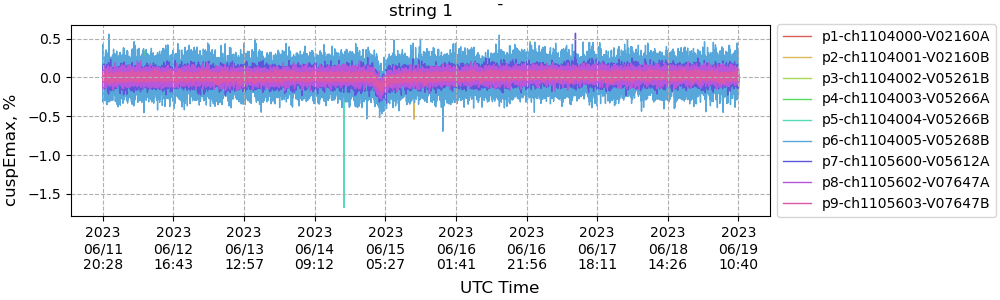

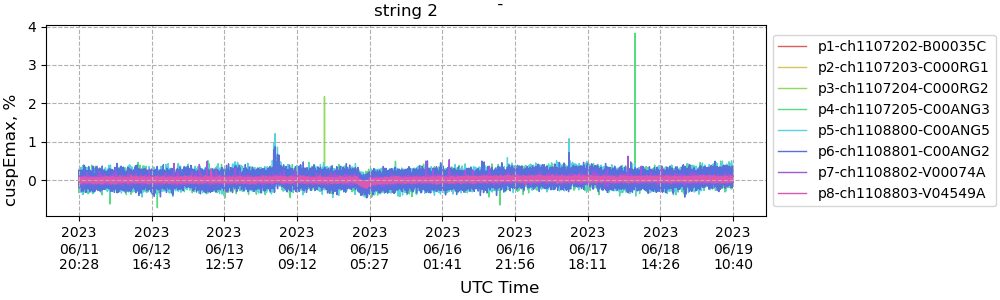

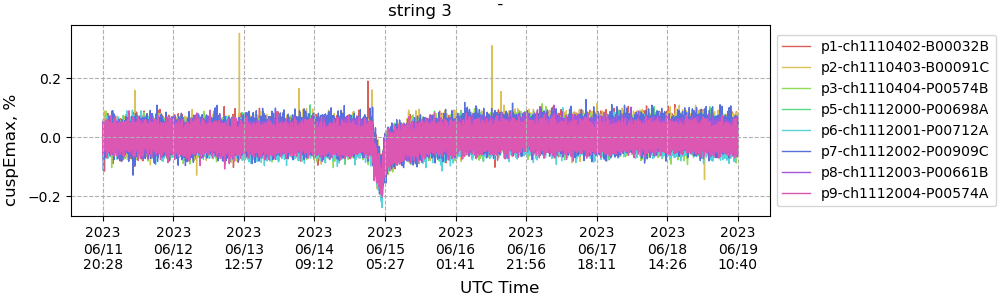

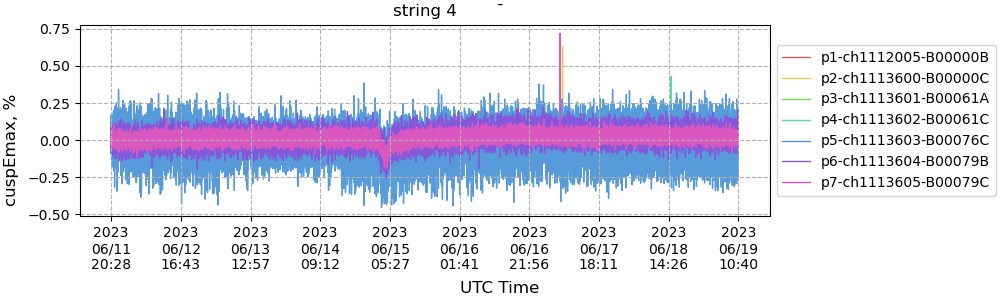

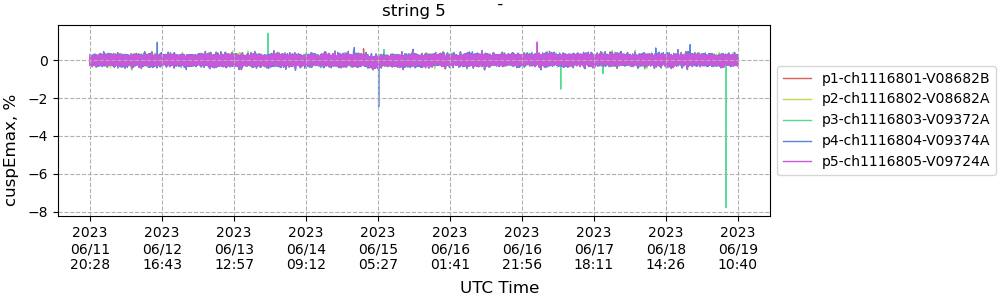

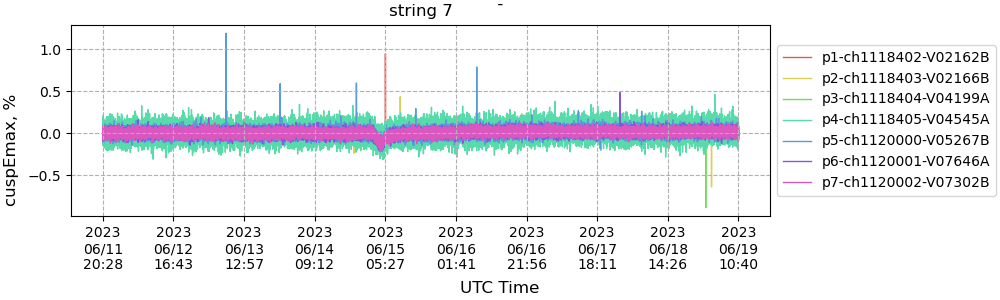

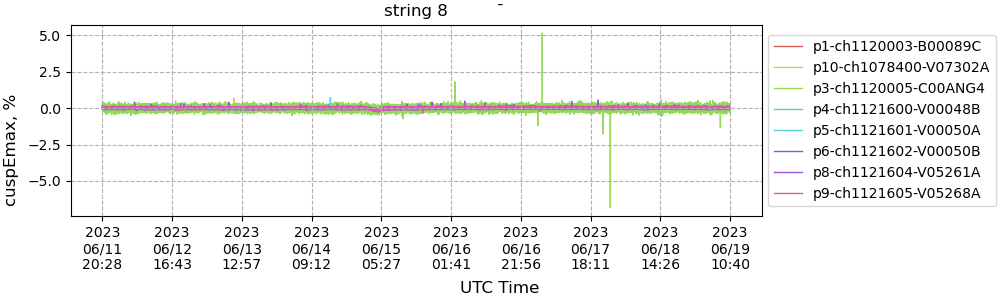

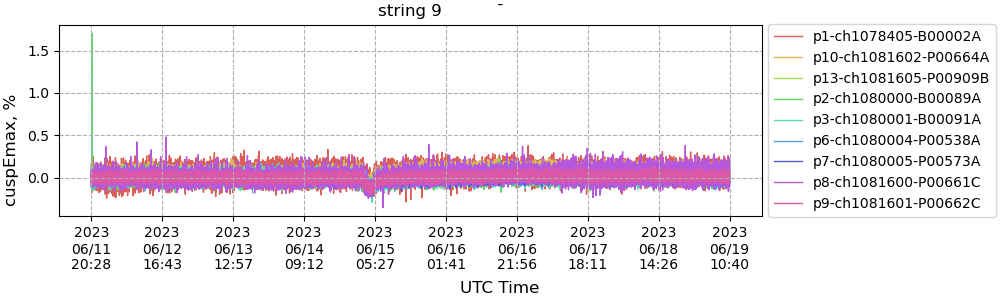

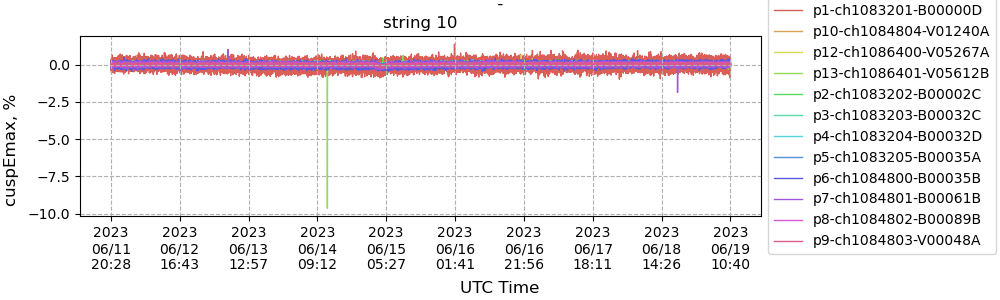

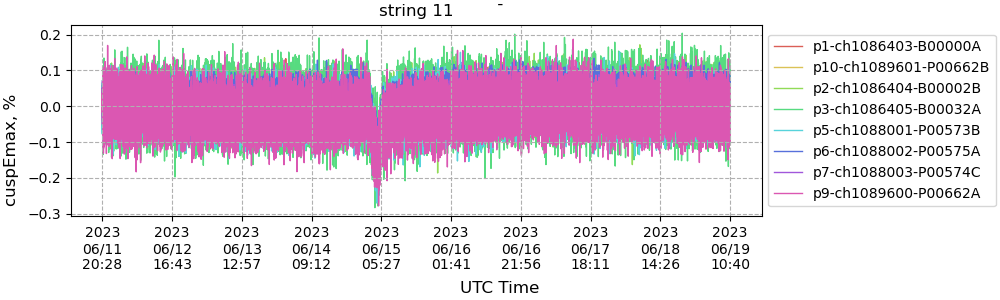

In [9]:
# set plotting options
plot_info = {
    "unit": df_info.loc["unit", "Value"],
    "label": df_info.loc["label", "Value"],
    "lower_lim_var": float(df_info.loc["lower_lim_var", "Value"])
    if limits_buttons.value == "yes"
    and to_None(df_info.loc["lower_lim_var", "Value"]) is not None
    else None,
    "upper_lim_var": float(df_info.loc["upper_lim_var", "Value"])
    if limits_buttons.value == "yes"
    and to_None(df_info.loc["upper_lim_var", "Value"]) is not None
    else None,
    "lower_lim_abs": float(df_info.loc["lower_lim_abs", "Value"])
    if limits_buttons.value == "yes"
    and to_None(df_info.loc["lower_lim_abs", "Value"]) is not None
    else None,
    "upper_lim_abs": float(df_info.loc["upper_lim_abs", "Value"])
    if limits_buttons.value == "yes"
    and to_None(df_info.loc["upper_lim_abs", "Value"]) is not None
    else None,
    "plot_style": plot_styles_widget.value,
    "plot_structure": plot_structures_widget.value,
    "resampled": resampled_widget.value,
    "title": "",
    "subsystem": "",
    "std": False,
    "locname": {
        "geds": "string",
        "spms": "fiber",
        "pulser": "puls",
        "pulser01ana": "pulser01ana",
        "FCbsln": "FC bsln",
        "muon": "muon",
    }[subsystem],
    "range": [min_input.value, max_input.value]
    if min_input.value < max_input.value
    else [None, None],
    "event_type": None,
    "unit_label": "%"
    if data_format_widget.value == "% values"
    else df_info.loc["unit", "Value"],
    "parameters": "",
    "time_window": radio_buttons.value.split("min")[0] + "T",
}


# turn on the std when plotting individual channels together
if plot_info["plot_structure"] == "per channel":
    plot_info["std"] = True

if data_format_widget.value == "absolute values":
    plot_info["limits"] = [plot_info["lower_lim_abs"], plot_info["upper_lim_abs"]]
    plot_info["parameter"] = (
        convert_to_original_format(param_widget.value)
        if param_widget.value != "BlMean"
        else param_widget.value
    )
    df_to_plot = new_df_param_orig.copy()
if data_format_widget.value == "% values":
    plot_info["limits"] = [plot_info["lower_lim_var"], plot_info["upper_lim_var"]]
    plot_info["parameter"] = (
        convert_to_original_format(param_widget.value) + "_var"
        if param_widget.value != "BlMean"
        else param_widget.value + "_var"
    )
    df_to_plot = new_df_param_var.copy()

print(f"Making plots now...")

if isinstance(strings_widget.value, str):  # let's get all strings in output
    for string in [1, 2, 3, 4, 5, 7, 8, 9, 10, 11]:
        if plot_structures_widget.value == "per channel":
            plotting.plot_per_ch(
                df_to_plot[df_to_plot["location"] == string], plot_info, ""
            )  # plot one canvas per channel
        elif plot_structures_widget.value == "per string":
            plotting.plot_per_string(
                df_to_plot[df_to_plot["location"] == string], plot_info, ""
            )  # plot one canvas per string
else:  # let's get one string in output
    if plot_structures_widget.value == "per channel":
        plotting.plot_per_ch(
            df_to_plot[df_to_plot["location"] == strings_widget.value], plot_info, ""
        )  # plot one canvas per channel
    elif plot_structures_widget.value == "per string":
        plotting.plot_per_string(
            df_to_plot[df_to_plot["location"] == strings_widget.value], plot_info, ""
        )  # plot one canvas per string

# Summary plots vs channels
Here you can monitor the distribution of a parameter across an entire run for all channels, grouped by string.  
Shown in this plot:
* **mean** value (horizontal green line) of the distribution
* **std** (blue box)
* **min/max** (black horizontal lines below/above the box)

In [14]:
print("Do you want to display horizontal lines for limits in the plots?")
display(container_limits)

Do you want to display horizontal lines for limits in the plots?


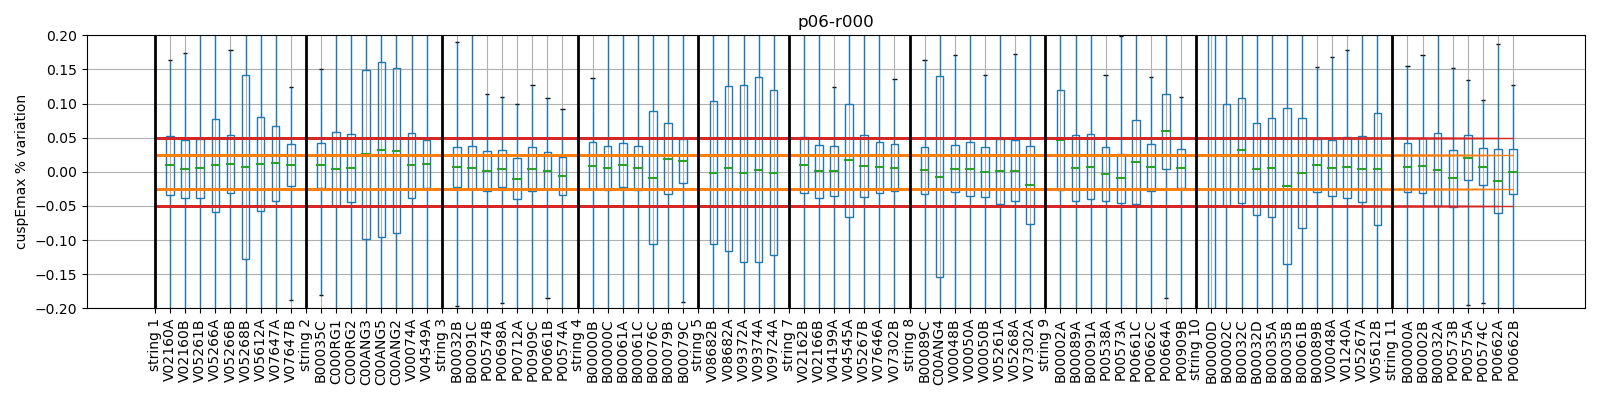

In [17]:
grouped_df = new_df_param_var.groupby(["location", "position", "name"]).cuspemax_var

my_df = pd.DataFrame()
my_df["mean"]     = grouped_df.mean()
my_df["std"]      = grouped_df.std()
my_df["minimum"]  = grouped_df.min()
my_df["maximum"]  = grouped_df.max()

# Create boxes for mean ± std and plot mean as a horizontal line
box_width = 0.5  # Width of the boxes
box_positions = np.arange(len(my_df))

# Create the figure and axis
fig, ax = plt.subplots( figsize = (16, 4))

l = 0.15

current_string = 0
current_index = -1
name_list = []
my_df.reset_index()

for index, row in my_df.reset_index().iterrows(): 
    
    if current_string != row["location"]:
        current_index += 1
        ax.vlines(current_index, -100, 100, color='black', linewidth = 2, zorder = 10)
        current_string = row["location"]
        name_list.append(f"string {row.location}")
        
    current_index += 1
        
    rect = Rectangle((current_index - box_width / 2, row["mean"] - row["std"]), box_width, 2 * row["std"], fill=False, edgecolor='tab:blue', linewidth = 1, zorder = 2)
    ax.add_patch(rect)
    ax.plot([current_index - box_width / 2, current_index + box_width / 2], [row["mean"], row["mean"]], color='tab:green', zorder = 2)
    ax.grid()

    # Plot horizontal black lines at min and max values
    ax.hlines(row["minimum"], current_index - l, current_index + l, color='k', zorder=2, linewidth = 1)
    ax.hlines(row["maximum"], current_index - l, current_index + l, color='k', zorder=2, linewidth = 1)
    
    # Plot vertical lines min and max values
    ax.vlines(current_index, row["std"] + row["mean"], row["maximum"], color='tab:blue', linewidth = 1)
    ax.vlines(current_index, row["minimum"], -row["std"] + row["mean"], color='tab:blue', linewidth = 1)
    
    name_list.append(row["name"])


if container_limits.value == "yes":
    # Plot lines for mean value thresholds
    ax.hlines(0.025, 0, len(name_list) - 1, color='tab:orange', zorder=3, linewidth = 1)
    ax.hlines(-0.025, 0, len(name_list) - 1, color='tab:orange', zorder=3, linewidth = 1)

    # Plot lines for std value thresholds
    ax.hlines(0.05, 0, len(name_list) - 1, color='tab:red', zorder=3, linewidth = 1)
    ax.hlines(-0.05, 0, len(name_list) - 1, color='tab:red', zorder=3, linewidth = 1)

# Set labels and title
ax.set_xticks(np.arange(len(name_list)))
ax.set_xticklabels(name_list, rotation = 90)

# Show plot
ax.set_ylim([-0.2, 0.2])
ax.set_ylabel("cuspEmax % variation")
ax.set_title(f"{period}-{run}")
plt.tight_layout()
plt.show()

In [8]:
# remove global spikes events by selecting their amplitude
# and 
# compute mean over initial hours of all DataFrame

new_df_param_var = new_df_param_var[new_df_param_var.cuspemax_var > -10]

channel_list = new_df_param_var["channel"].unique()

# recalculate % variation wrt new mean value for all channels
for ch in channel_list:
    channel_df   = new_df_param_var[new_df_param_var["channel"] == ch]
    channel_mean = channel_df["cuspemax_var"].iloc[0:int(0.1*len(channel_df))].mean()
    new_ch_var   = (channel_df["cuspemax_var"] - channel_mean)/channel_mean*100
    new_df_param_var.loc[new_df_param_var["channel"] == ch, param_widget.value + "_var"] = new_ch_var